# Detection of Brain Tumors through Convolutional Neural Networks (CNNs) utilizing Residual Networks (ResNets) and Visual Geometry Group (VGG) Architectures

The purpose of this segment of the project is to explore critical aspects such as data visualization, data preprocessing, and performance evaluation of the implemented models. Our objectives are to gain insight into the dataset, refine the data for optimal model input, and evaluate the effectiveness of the models we have selected.

Following the conclusion of the current phase, the next step will be to localize brain tumor images using ResUnet. In this pivotal step, the project's capabilities in detecting and analyzing brain tumors are further enhanced by precisely identifying and delineating the regions of interest within the medical images.


When running any code it’s beneficial to change the “RunTime” type to T4-GPU

#1: IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize

import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline


In [16]:
# mount the drive using the following commands: (For Examiner: Only run if you have transfered the folder to your drive. Detials Explained in the report [Appendix])

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Navigating my Drive directory to find dataset (For Examiner: Only run if you have transfered the folder to your drive. Detials Explained in the report [Appendix])

%cd /content/drive/My Drive/Final Project/BrainTumor Project/Brain_MRI

/content/drive/My Drive/Final Project/BrainTumor Project/Brain_MRI


In [19]:
# data containing path to Brain MRI and their corresponding mask

brain_df = pd.read_csv('data_mask.csv')

In [20]:
# Display information about the Dataset

brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [21]:
# Display the first 5 rows of the dataset (The dataset contains a 'patient_id', 'image_path' of the MRI image, 'mask_path' located in the image and the 'mask')

brain_df.head(5)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


#2: DATA VISUALISATION

In [22]:
# Obtain the number of images with mask (mask basically means if it is a '0' they are no tumor and if it is a '1' they is tumor established)

brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [23]:
# interactive bar chart showing mask

import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)

fig.update_layout(title_text="Mask", title_x=0.5, title_y=0.05)
fig.show()

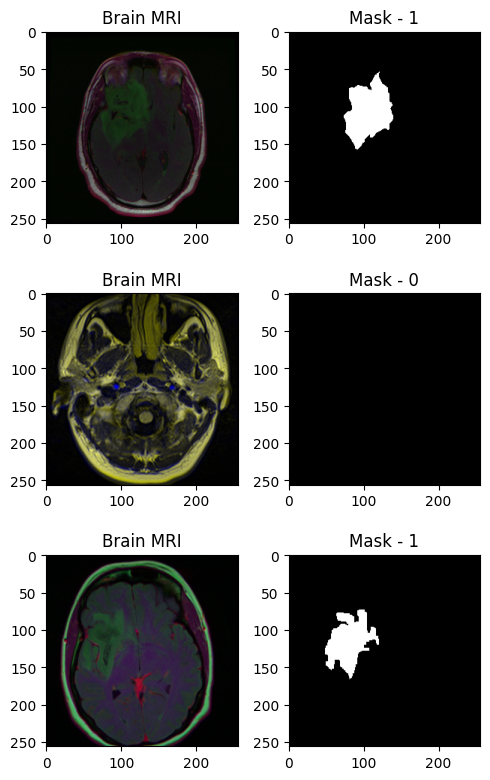

In [ ]:
# Visualising the images (MRI and Mask randomly) in the dataset separately

import random
fig, axs = plt.subplots(3, 2, figsize=(5, 8))
count = 0
for x in range(3):  # Change the loop to iterate 3 times
    i = random.randint(0, len(brain_df))  # select a random index
    axs[count][0].title.set_text("Brain MRI")  # set title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))  # show MRI
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))  # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))  # Show corresponding mask
    count += 1

fig.tight_layout()
plt.show()

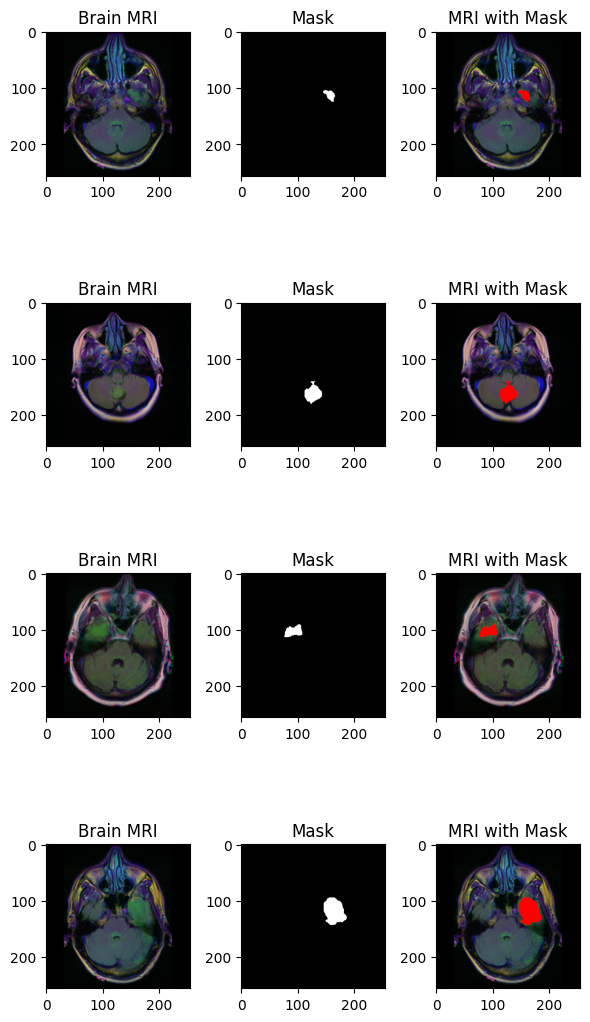

In [ ]:
# visualising the MRI scans along with their mask on one image

count = 0
fig, axs = plt.subplots(4, 3, figsize=(6, 11))
for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and count < 4:
        # read the images
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        # obtain the mask for the image
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')

        # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count += 1

fig.tight_layout()


#3a: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT (RESNET)

In [24]:
# Drop the patient id column

brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [25]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [26]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [27]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [28]:
# create a image generator

from keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [29]:
# Create a data generator for train images

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [30]:
# Create a data generator for test images

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 590 validated image filenames belonging to 2 classes.


In [31]:
# Get the ResNet50 base model     # The input shape (256, 256, 3) indicates that model expects input images with Width, height: 256 pixels and Color Channels: 3.

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 5s 0us/step


In [32]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [33]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [34]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [35]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [36]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Training the model

history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 10, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/10
177/177 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.6773
Epoch 1: val_loss improved from inf to 3.49257, saving model to classifier-resnet-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



177/177 [==============================] - 76s 269ms/step - loss: 0.7961 - accuracy: 0.6773 - val_loss: 3.4926 - val_accuracy: 0.6694
Epoch 2/10
177/177 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7329
Epoch 2: val_loss improved from 3.49257 to 0.66029, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 47s 263ms/step - loss: 0.5089 - accuracy: 0.7329 - val_loss: 0.6603 - val_accuracy: 0.6714
Epoch 3/10
177/177 [==============================] - ETA: 0s - loss: 0.4276 - accuracy: 0.7761
Epoch 3: val_loss did not improve from 0.66029
177/177 [==============================] - 43s 241ms/step - loss: 0.4276 - accuracy: 0.7761 - val_loss: 0.7069 - val_accuracy: 0.3468
Epoch 4/10
177/177 [==============================] - ETA: 0s - loss: 0.3469 - accuracy: 0.8378
Epoch 4: val_loss did not improve from 0.66029
177/177 [==============================] - 42s 238ms/step - loss: 0.3469 - accuracy: 0.8378 - val_loss: 0.8782 - val_

In [ ]:
# Interactive graph of the Training and Validation Loss

import plotly.graph_objects as go

# Access training loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs (e.g., [1, 2, 3, ...])
epochs = list(range(1, len(train_loss) + 1))  # Convert range to a list

# Create a Plotly figure
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss'))

# Add validation loss trace
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss'))

# Set layout options and adjust figure size
fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    hovermode='closest',  # Enables interactive hovering
    width=800,  # Adjust the width in pixels
    height=400  # Adjust the height in pixels
)

# Show the interactive plot
fig.show()

In [ ]:
# Interactive graph of the Training and Validation Accuracy

# Access training accuracy and validation accuracy from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs (e.g., [1, 2, 3, ...])
epochs = list(range(1, len(train_accuracy) + 1))  # Convert range to a list

# Create a Plotly figure
fig = go.Figure()

# Add training accuracy trace
fig.add_trace(go.Scatter(x=epochs, y=train_accuracy, mode='lines+markers', name='Training Accuracy'))

# Add validation accuracy trace
fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines+markers', name='Validation Accuracy'))

# Set layout options and adjust figure size
fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    hovermode='closest',  # Enables interactive hovering
    width=800,  # Adjust the width in pixels
    height=400  # Adjust the height in pixels
)

# Show the interactive plot
fig.show()

#3b: ASSESS TRAINED MODEL PERFORMANCE (RESNET)

In [37]:
# Load pretrained model (instead of training the model for 1+ hours)

with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [38]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 439s 12s/step


In [39]:
test_predict.shape

(576, 2)

In [40]:
# Obtain the predicted class from the model prediction

predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '1', '1', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0',
       '1', '0', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1',
       '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0',
       '1', '1', '1', '0', '1', '0', '1', '0', '0', '0', '1', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0',
       '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '1', '0',
       '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '1',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0

In [42]:
# since we have used test generator, it limited the images to len(predict), due to batch size

original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [43]:
# Obtain the accuracy of the model

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)

print("Accuracy: ", accuracy)

Accuracy:  0.9878472222222222


In [44]:
# Classification Report

from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       376
           1       0.98      0.98      0.98       200

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



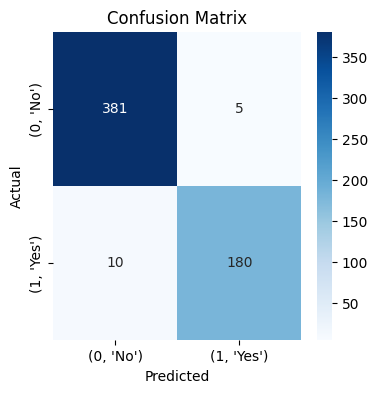

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(original, predict)

# Define class labels
class_labels = ["(0, 'No')", "(1, 'Yes')"]

# Create a figure and axis for the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

#4a: Building a Segmentation RESUNET to localize tumor

In [45]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [46]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)


In [47]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [48]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [49]:
def resblock(X, f):


  # make a copy of input
  X_copy = X

  # main path

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [50]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [51]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


#4b: Training a Segmentation RESUNET to localize tumor

In [52]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

# Compile the model
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [53]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [55]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

#4c: Assessing Trianed Segmentation RESUNET Model Performance

In [56]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [57]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

1/1 [==============================] - 0s 23ms/step


In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

,image_path,predicted_mask,has_mask
0,TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44...,No mask,0
1,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_22...,"[[[[7.8720217e-07], [3.3678311e-06], [9.354834...",1
2,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46...,"[[[[8.768509e-07], [2.9692685e-06], [4.9538876...",1
3,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30...,No mask,0
4,TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14...,"[[[[8.568254e-07], [4.346741e-06], [1.2575461e...",1
...,...,...,...
585,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_14...,No mask,0
586,TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_31...,"[[[[8.1964964e-07], [2.8634345e-06], [5.421273...",1
587,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_38...,"[[[[8.099359e-07], [2.6119708e-06], [4.606941e...",1
588,TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_34...,No mask,0


In [ ]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44...,TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44...,0,No mask,0
1,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_22...,TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_22...,1,"[[[[7.8720217e-07], [3.3678311e-06], [9.354834...",1
2,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46...,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46...,1,"[[[[8.768509e-07], [2.9692685e-06], [4.9538876...",1
3,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30...,TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30...,0,No mask,0
4,TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14...,TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14...,1,"[[[[8.568254e-07], [4.346741e-06], [1.2575461e...",1


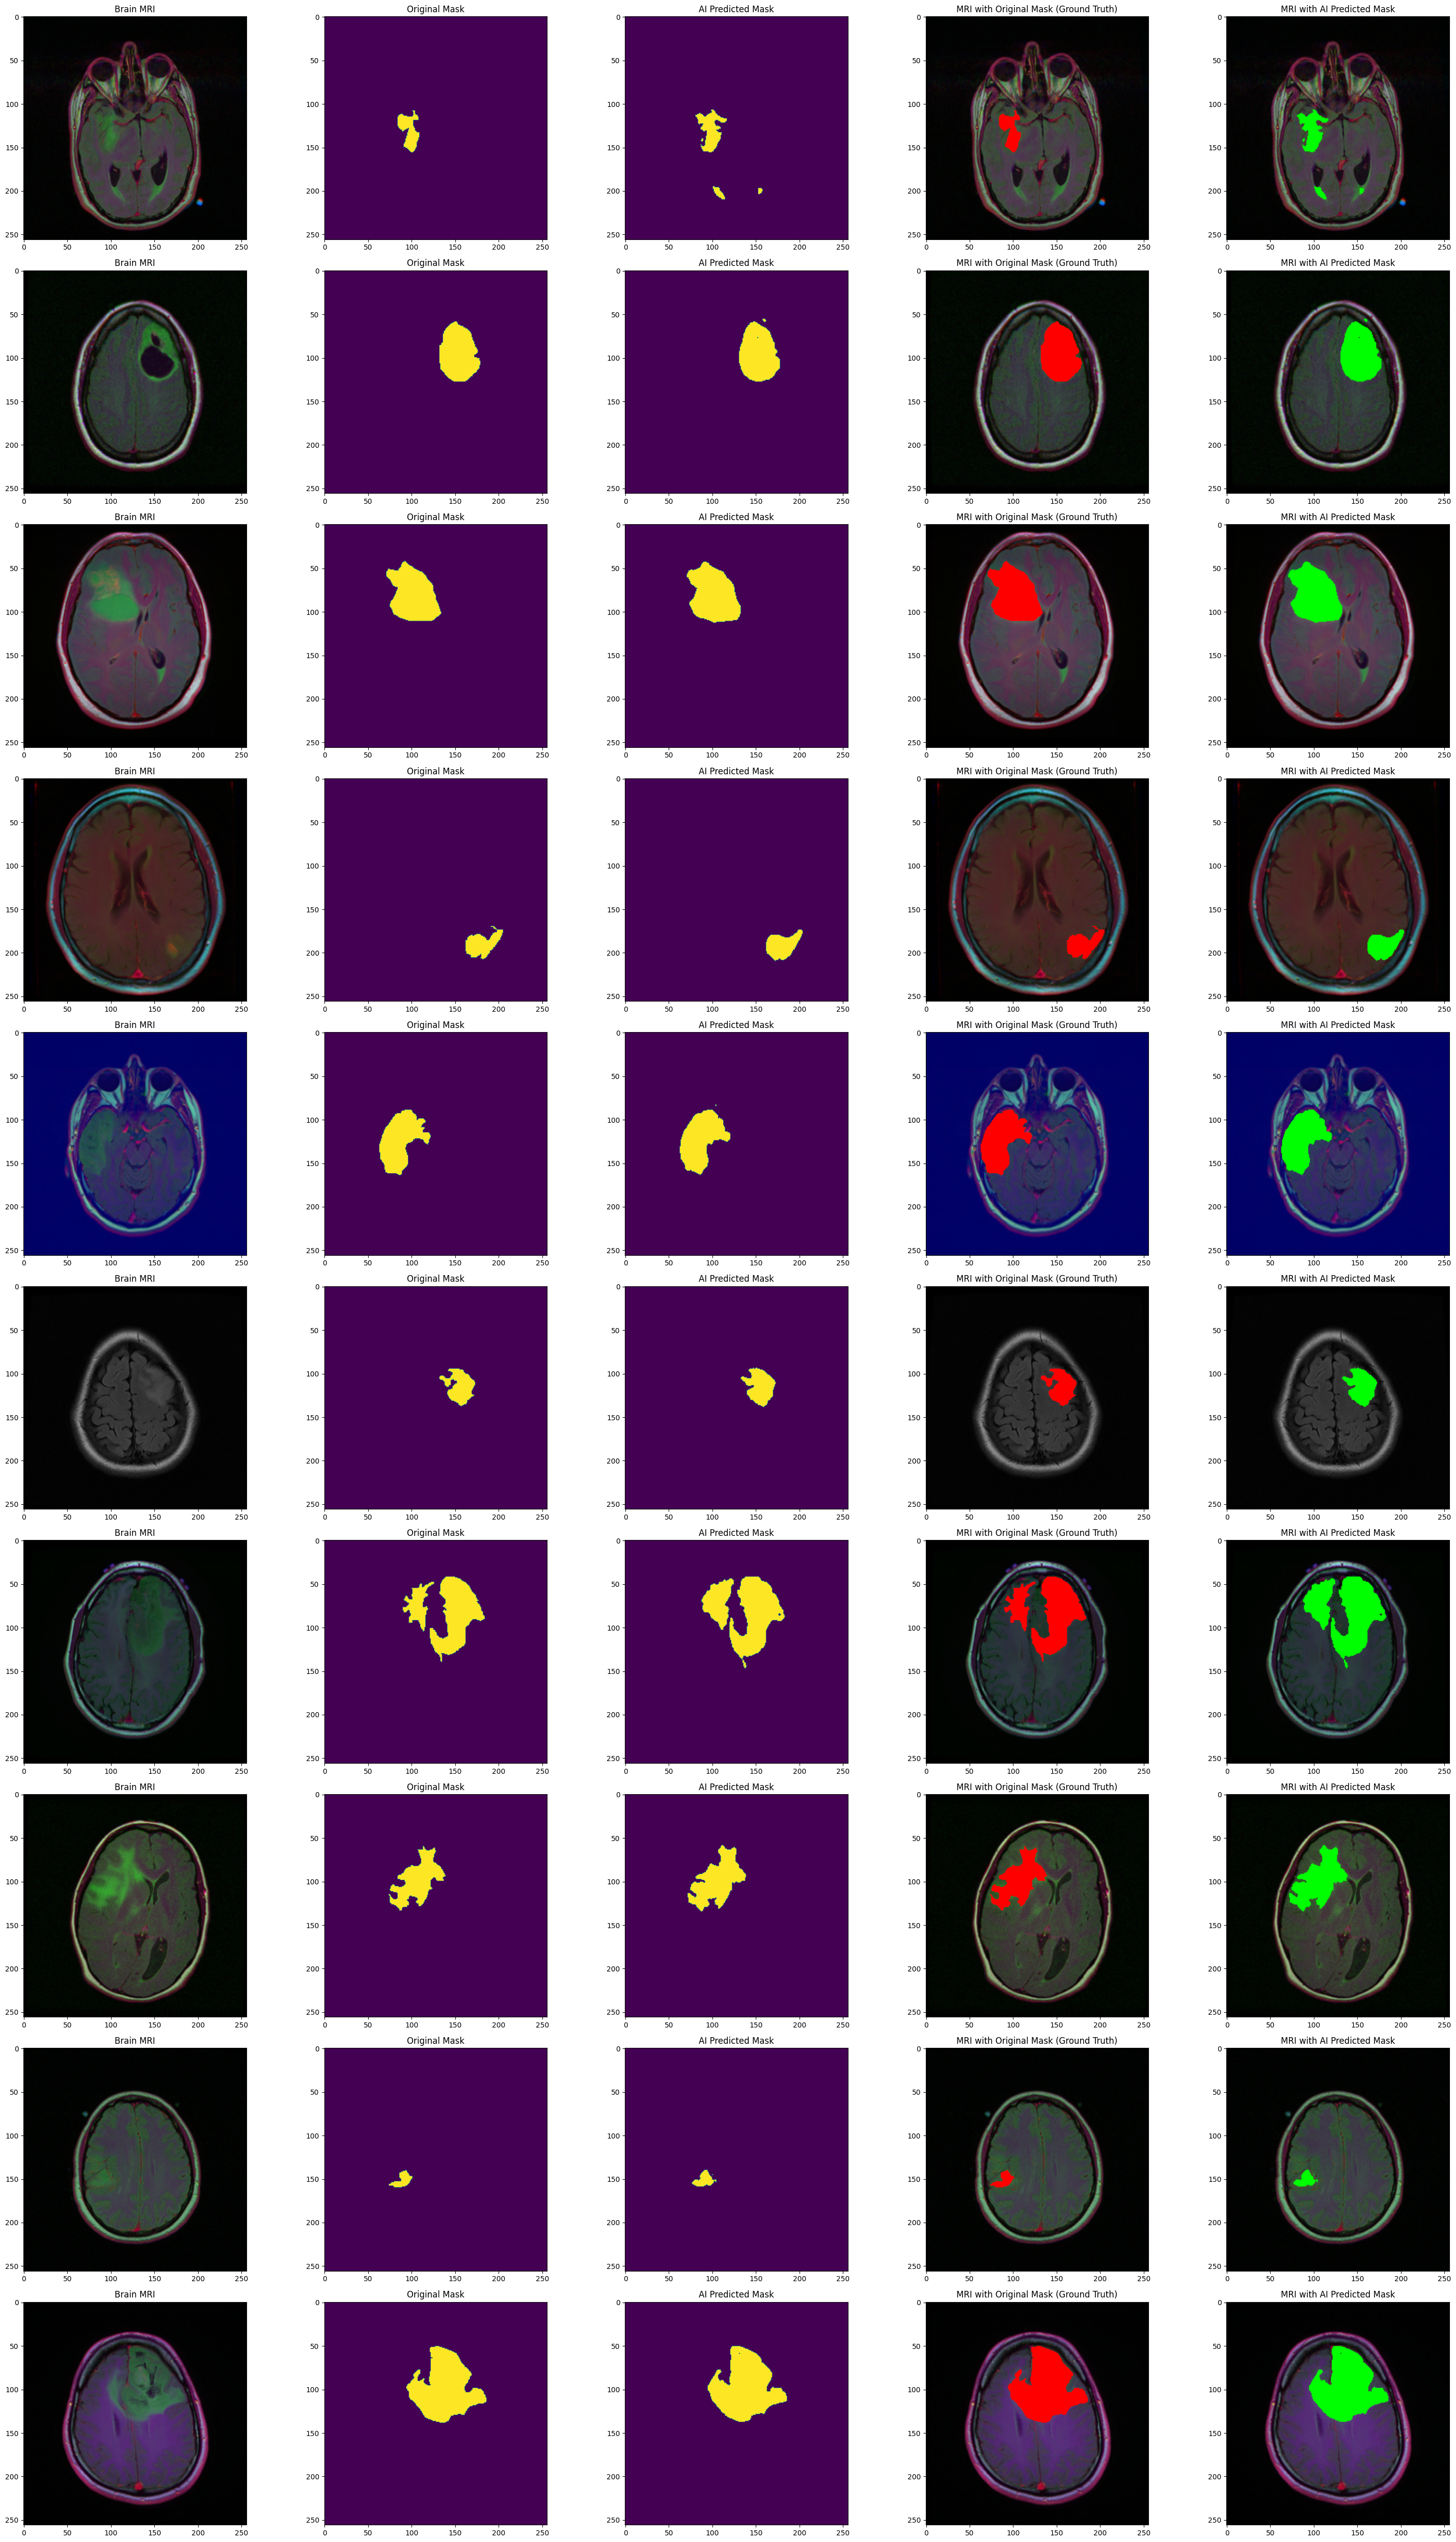

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()